# Real Hardware Fitting

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

## Expectation Value

## Two Qubit POVM with Trace

In [2]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    #for i, angle in enumerate(theta[2*n:3*n]):
    #    circuit.ry(angle, i)
        
    #for i, angle in enumerate(theta[3*n:]):
    #    circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [3]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM_notrace.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(4, 4), dtype=complex64)
[[9.855e-01 2.131e-02 3.199e-02 6.125e-04]
 [6.612e-03 1.250e-04 9.600e-01 2.120e-02]
 [7.800e-03 9.715e-01 1.625e-04 3.213e-02]
 [6.250e-05 7.112e-03 7.875e-03 9.461e-01]]


In [4]:
target_list = []
input_list_ = []
for i in range(324):
    counts = counts_list[i]
    target_list.append(counts_to_probs(counts))
    state, U_basis, _ = input_list[i]
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), _])

input_list = input_list_

In [9]:
n = 2
d = 2**n
rank = 8
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm_ideal(n),
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [10]:
model.train(num_iter = 200,
            N = 25
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.11628172+3.5316798e-09j)
1 (0.113025926+1.3441558e-09j)
2 (0.1087859+3.4779408e-09j)
3 (0.103742585+3.830349e-09j)
4 (0.098201066+1.5522471e-09j)
5 (0.09366857+3.7733745e-09j)
6 (0.089076616+1.5763016e-09j)
7 (0.08469532+3.3073722e-09j)
8 (0.08002086+1.243532e-09j)
9 (0.07556263+1.0376462e-09j)
10 (0.071316004+1.5125423e-09j)
11 (0.067446485+2.3588207e-09j)
12 (0.06378859+1.8440195e-09j)
13 (0.060338844+2.355985e-09j)
14 (0.057092756+1.6614047e-09j)
15 (0.0539351+1.6856258e-09j)
16 (0.050836485+6.7054245e-10j)
17 (0.047622737+1.869997e-09j)
18 (0.044158965+1.1362313e-09j)
19 (0.040781226+1.2485036e-09j)
20 (0.0374441+1.0953032e-09j)
21 (0.03433544+1.7082316e-09j)
22 (0.031445175+8.0716517e-10j)
23 (0.028743522+5.1299137e-10j)
24 (0.02623445+6.079488e-10j)
25 (0.023937032+3.5774286e-10j)
26 (0.021763097+6.389224e-10j)
27 (0.019804474+6.841928e-10j)
28 (0.017996252+9.71259e-10j)
29 (0.016395442+4.8857146e-10j)
30 (0.014939601+5.0181065e-10j)
31 (0.013609341+1.9159872e-10j)
32 (0.012

In [13]:
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.zeros(2**n)
observ[1] = 1
observ = tf.cast(observ, dtype=tf.complex64)
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[324:-16]]
counts_list[324:-16]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

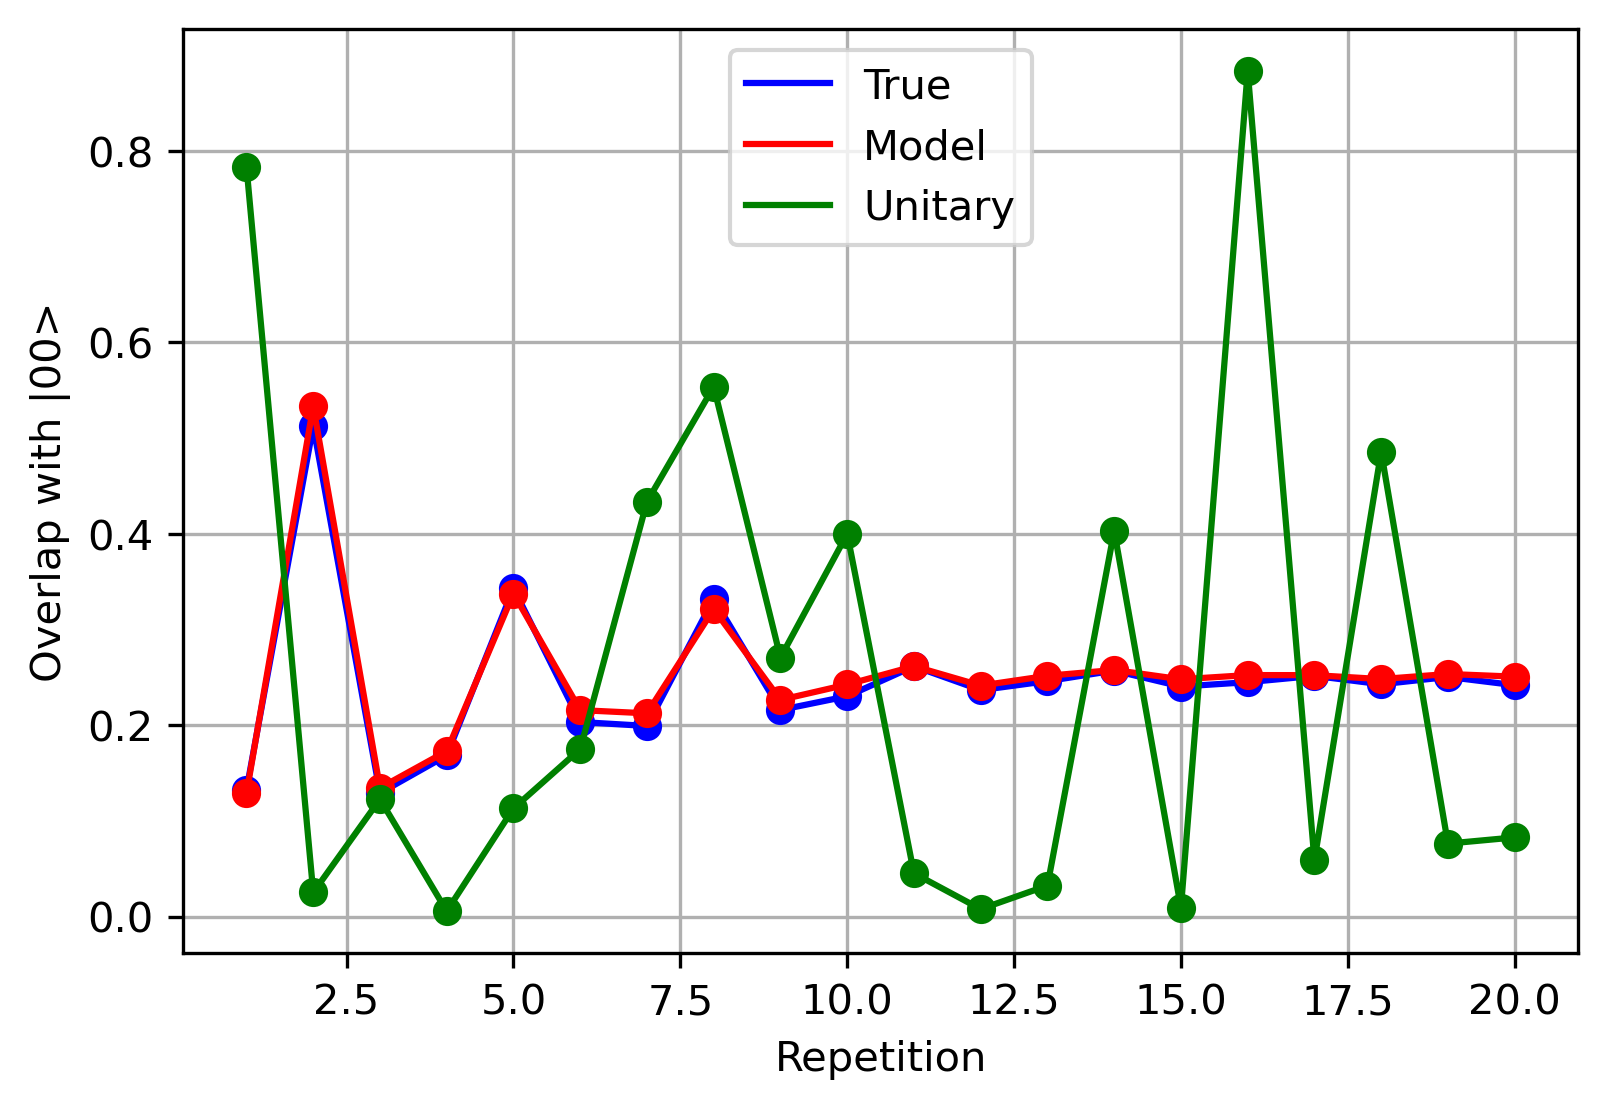

In [14]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()